In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F

import time, pathlib, os

## 2D dataset

In [8]:
# The two-dimensional domain of the fit.....
########https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/#########
x1min, x1max, nx1 = -5, 6, 75
x2min, x2max, nx2 = -3, 7, 75
x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
X1, X2 = np.meshgrid(x1, x2)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
    return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
# The function to be fit is Z.
Y = np.zeros(X1.shape)
for p in gprms:
    Y += gaussian(X1, X2, *p)
### Adding noise to the data
# noise_sigma = 0.1
# Z += noise_sigma * np.random.randn(*Z.shape)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y/2

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

In [20]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
# X1 = np.linspace(-2.5, 0, num_points)
X2 = np.linspace(-2, 4, num_points)
# X2 = np.linspace(-2, 2, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

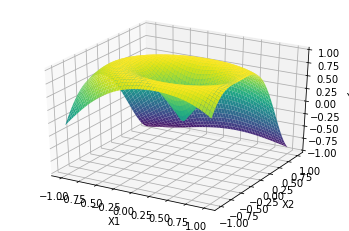

In [21]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='viridis')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
# plt.show()
plt.savefig("./invex_out/regression_1.pdf", bbox_inches='tight')

In [19]:
# %matplotlib inline
# fig = plt.figure()
# plt.contourf(X1, X2, Y, cmap='viridis')
# plt.contour(X1, X2, Y, cmap='viridis')

# plt.xlabel('X1')
# plt.ylabel('X2')
# # plt.savefig("./invex_out/regression_2.pdf", bbox_inches='tight')

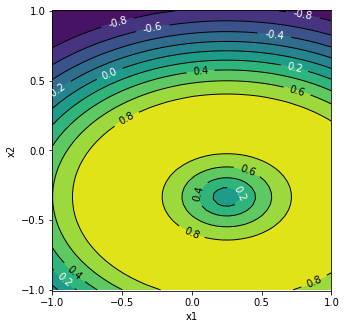

In [22]:
plt.figure(figsize=(6/6*5,6.2/6*5))
plt.axis('equal')

lvls = 12
plt.contourf(X1, X2, Y, levels=lvls)#, cmap=matplotlib.cm.bwr)

clrs = ['white','white','white','white','white','white','white','k','k','k','k','k']
cs = plt.contour(X1, X2, Y, levels=lvls, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.1f", colors=clrs)

plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.savefig("./invex_out/regression_1c.pdf", bbox_inches='tight')

In [23]:
def twospirals(n_points, noise=.5 , ang=720):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * ang * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

np.random.seed(987)
# x, y = twospirals(200, ang=420)
x, y = twospirals(200, ang=400)
x, Y = x/10, y.reshape(-1)
X1, X2 = x[:,0], x[:,1]

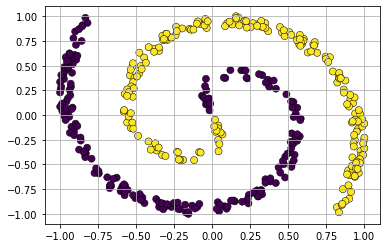

In [24]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
plt.scatter(X1, X2, c=Y, s=50, edgecolors='k', lw=0.5)
plt.grid()
plt.savefig("./invex_out/classification_1.pdf", bbox_inches='tight')

In [31]:
yy.shape

torch.Size([2500, 1])

In [13]:
network_seeds = [147, 258, 369]
lambda_ = 1 #[1, 3]
learning_rate = 0.005 #0.01 0.005
EPOCHS = 7500 #5000 #7500

actf = nn.LeakyReLU
# actf = nn.ELU

In [14]:
# criterion = nn.MSELoss()
# use_sigmoid = False

criterion = nn.BCELoss()
use_sigmoid = True

In [15]:
class Sigmoid4(nn.Module):
    
    def forward(self,x):
        return torch.sigmoid(x*4)
nn.Sigmoid = Sigmoid4

## Gradient Clipped Lipschitz Penalty (Ours)

In [16]:
class LipschitzNet(nn.Module):
    
    def __init__(self, net, K=1., lamda=1.):
        super().__init__()
        
        self.net = net
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx = None
        self.K = K
        
        self.gp = 0
        self.gclipper = torch.Tensor([999])
        
    def forward(self, x):
        self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        y.register_hook(self.scale_gradient_back)
        return y
    
    def scale_gradient_back(self, grad):
#         print("Old", grad.shape)
#         grad = torch.min(torch.max(grad, -self.gclipper), self.gclipper)
#         print("New", grad.shape)
#         return grad
#         return torch.min(torch.max(grad, -self.gclipper), self.gclipper)
        return torch.minimum(torch.maximum(grad, -self.gclipper), self.gclipper)

    
    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def get_gradient_penalty(self):
#         m = self.dydx.shape[0]
        dydx_norm = torch.norm(self.dydx, p=2, dim=1, keepdim=True)
#         self.cond = -(torch.abs(dydx_norm/self.K) -1.)
        self.cond = -dydx_norm/self.K +1.
        
#         a=-20
#         intolerables = torch.log(torch.exp(a*(self.cond-0.1))+1)/a
#         dydx_norm = torch.norm(self.dydx.data, p=2, dim=1, keepdim=True)
#         self.gp = 0.5*((intolerables*5)**2).mean()*self.lamda

#         intolerables = torch.clamp(F.softplus(self.cond-0.1, beta=-20), -1, 1)
        intolerables = F.softplus(self.cond-0.1, beta=-20)
#         intolerables = F.softplus(F.softplus(self.cond-0.1, beta=-20)+2, beta=5)-2

        self.gp = (self.smooth_l1(intolerables*5)).mean()*self.lamda
        
    
#         self.gp = 0.5*(intolerables**2).sum()*self.lamda
        
#         intolerables = torch.min(self.cond-1e-1, torch.zeros_like(self.cond))
#         self.gp = 0.5*(intolerables**2).mean()*self.lamda
#         self.gp = torch.abs(intolerables).mean()*self.lamda
#         self.gp = 0.5*(torch.abs(intolerables)+intolerables**2).mean()*self.lamda

        return self.gp
    
    ##
    def get_gradient_clipper(self):
        with torch.no_grad():
            cond = self.cond.data
            linear_mask = cond>0.14845
#             print(dydx.shape, linear_mask.shape)
            a = 20.
            gclipper = -((1.05*(cond-1))**4)+1
            gclipper = torch.log(torch.exp(a*gclipper)+1)/a
#             print(gclipper.shape)
            gc2 = 3*cond-0.0844560006
#             print(gc2.shape)
            gclipper[linear_mask] = gc2[linear_mask]
#             print(gclipper.shape)
#             gclipper = torch.clamp(gclipper, min=0.01)
            self.gclipper = gclipper
            
        return self.gclipper

    def smooth_l1(self, x, beta=1):
        mask = x<beta
        y = torch.empty_like(x)
        y[mask] = 0.5*(x[mask]**2)/beta
        y[~mask] = torch.abs(x[~mask])-0.5*beta
        return y
    
    def compute_penalty_and_clipper(self):
        self.get_dydx()
        self.get_gradient_penalty()
        self.get_gradient_clipper()
        return

Epoch: 0, Loss:0.7050235867500305, MinCond: 0.749189019203186, MaxK: 0.25081101059913635, MinK: 0.0034462923649698496
Epoch: 100, Loss:0.42808014154434204, MinCond: -0.015763401985168457, MaxK: 1.0157634019851685, MinK: 0.05921311303973198
Epoch: 200, Loss:0.34719789028167725, MinCond: -0.054030537605285645, MaxK: 1.0540305376052856, MinK: 0.18890458345413208
Epoch: 300, Loss:0.34337884187698364, MinCond: -0.20835304260253906, MaxK: 1.208353042602539, MinK: 0.15546749532222748
Epoch: 400, Loss:0.3376488983631134, MinCond: -0.15933871269226074, MaxK: 1.1593387126922607, MinK: 0.15172278881072998
Epoch: 500, Loss:0.34200912714004517, MinCond: -0.059923768043518066, MaxK: 1.059923768043518, MinK: 0.14967966079711914
Epoch: 600, Loss:0.33842164278030396, MinCond: -0.1048198938369751, MaxK: 1.104819893836975, MinK: 0.15771296620368958
Epoch: 700, Loss:0.3342938721179962, MinCond: -0.13307976722717285, MaxK: 1.1330797672271729, MinK: 0.1716754138469696
Epoch: 800, Loss:0.3300502896308899, Mi

Epoch: 6800, Loss:0.32384082674980164, MinCond: -0.05313456058502197, MaxK: 1.053134560585022, MinK: 0.13759277760982513
Epoch: 6900, Loss:0.32380902767181396, MinCond: -0.05869710445404053, MaxK: 1.0586971044540405, MinK: 0.11472964286804199
Epoch: 7000, Loss:0.32346218824386597, MinCond: -0.058934569358825684, MaxK: 1.0589345693588257, MinK: 0.23019376397132874
Epoch: 7100, Loss:0.3295987844467163, MinCond: -0.02579367160797119, MaxK: 1.0257936716079712, MinK: 0.25028279423713684
Epoch: 7200, Loss:0.3245082497596741, MinCond: -0.05775177478790283, MaxK: 1.0577517747879028, MinK: 0.13374818861484528
Epoch: 7300, Loss:0.323365718126297, MinCond: -0.0457911491394043, MaxK: 1.0457911491394043, MinK: 0.23195762932300568
Epoch: 7400, Loss:0.3240516781806946, MinCond: -0.06453597545623779, MaxK: 1.0645359754562378, MinK: 0.2613697946071625
Epoch: 0, Loss:0.704268217086792, MinCond: 0.9104670286178589, MaxK: 0.08953297138214111, MinK: 0.008460799232125282
Epoch: 100, Loss:0.41030681133270264

Epoch: 6100, Loss:0.3035109043121338, MinCond: -0.09790122509002686, MaxK: 1.0979012250900269, MinK: 0.41256046295166016
Epoch: 6200, Loss:0.30387356877326965, MinCond: -0.09448587894439697, MaxK: 1.094485878944397, MinK: 0.3988815248012543
Epoch: 6300, Loss:0.3048527240753174, MinCond: -0.09690511226654053, MaxK: 1.0969051122665405, MinK: 0.41001230478286743
Epoch: 6400, Loss:0.30327939987182617, MinCond: -0.08664107322692871, MaxK: 1.0866410732269287, MinK: 0.4073885679244995
Epoch: 6500, Loss:0.30393317341804504, MinCond: -0.07559144496917725, MaxK: 1.0755914449691772, MinK: 0.27349355816841125
Epoch: 6600, Loss:0.30389127135276794, MinCond: -0.10383439064025879, MaxK: 1.1038343906402588, MinK: 0.1291787326335907
Epoch: 6700, Loss:0.30480632185935974, MinCond: -0.0752338171005249, MaxK: 1.075233817100525, MinK: 0.2399711161851883
Epoch: 6800, Loss:0.3054916262626648, MinCond: -0.04770541191101074, MaxK: 1.0477054119110107, MinK: 0.06689151376485825
Epoch: 6900, Loss:0.30399233102798

Epoch: 5400, Loss:0.32505959272384644, MinCond: -0.03576493263244629, MaxK: 1.0357649326324463, MinK: 0.29203343391418457
Epoch: 5500, Loss:0.3226497173309326, MinCond: -0.05347466468811035, MaxK: 1.0534746646881104, MinK: 0.0890858918428421
Epoch: 5600, Loss:0.32428207993507385, MinCond: -0.05886495113372803, MaxK: 1.058864951133728, MinK: 0.10385573655366898
Epoch: 5700, Loss:0.32302990555763245, MinCond: -0.02819371223449707, MaxK: 1.028193712234497, MinK: 0.1129160150885582
Epoch: 5800, Loss:0.3254736065864563, MinCond: -0.09491026401519775, MaxK: 1.0949102640151978, MinK: 0.11149323731660843
Epoch: 5900, Loss:0.3266860842704773, MinCond: -0.2648937702178955, MaxK: 1.2648937702178955, MinK: 0.09831848740577698
Epoch: 6000, Loss:0.323919415473938, MinCond: -0.31074821949005127, MaxK: 1.3107482194900513, MinK: 0.11631303280591965
Epoch: 6100, Loss:0.3255172371864319, MinCond: -0.045519113540649414, MaxK: 1.0455191135406494, MinK: 0.12582726776599884
Epoch: 6200, Loss:0.32446220517158

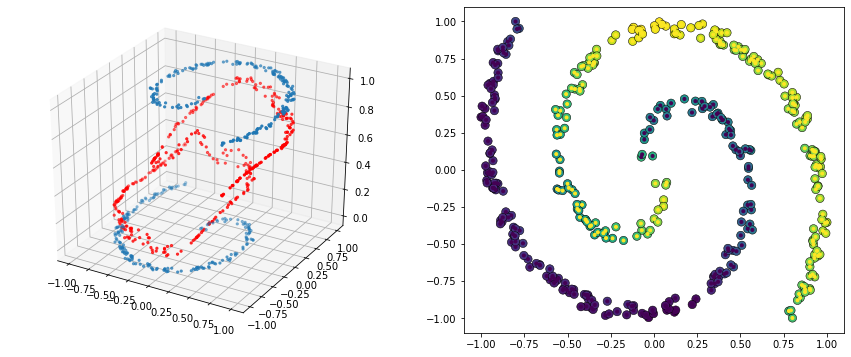

In [11]:
%matplotlib tk


per_step_time = []
info_per_seed = []

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
# ax.view_init(28,20)

for ns in network_seeds:
    torch.manual_seed(ns)

    net_lips = nn.Sequential(nn.Linear(2,10),
                             actf(),
                             nn.Linear(10,10),
                             actf(),
                             nn.Linear(10,1),
                             nn.Sigmoid() if use_sigmoid else nn.Identity())

    lipsNet = LipschitzNet(net_lips, K=1, lamda=lambda_)


    optimizer = torch.optim.Adam(lipsNet.parameters(), lr=learning_rate)

    for epoch in range(EPOCHS):
        start = time.time()

        yout = lipsNet(xx)    
        lipsNet.compute_penalty_and_clipper()
        loss = criterion(yout, yy) + lipsNet.gp

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        per_step_time.append(time.time()-start)

        if epoch%100 == 0:
            min_val = float(lipsNet.cond.min())
            max_k = float(torch.norm(lipsNet.dydx, p=2, dim=1, keepdim=True).max())
            min_k = float(torch.norm(lipsNet.dydx, p=2, dim=1, keepdim=True).min())
            print(f'Epoch: {epoch}, Loss:{float(loss-lipsNet.gp)}, MinCond: {min_val}, MaxK: {max_k}, MinK: {min_k}')

            ax.clear()
            ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
            ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')

            ax2.clear()
            if use_sigmoid:
                ax2.scatter(X1, X2, c=yout.data.numpy().reshape(Y.shape), s=70, edgecolors='k', lw=0.5)
                ax2.scatter(X1, X2, c=Y, marker='.')
            else:
                ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

            fig.canvas.draw()
            plt.pause(0.01)
            
    if use_sigmoid:
        acc = float(((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100)
        info_per_seed.append(
            f'Epoch: {epoch}, Loss:{float(loss-lipsNet.gp)}, MinCond: {min_val}, MaxK: {max_k}, MinK: {min_k}, Acc: {acc}'
        )
    else:
        info_per_seed.append(f'Epoch: {epoch}, Loss:{float(loss-lipsNet.gp)}, MinCond: {min_val}, MaxK: {max_k}, MinK: {min_k}')

In [12]:
for i in range(len(info_per_seed)):
    print(i, network_seeds[i], info_per_seed[i])
print(np.mean(per_step_time), np.std(per_step_time))

0 147 Epoch: 7499, Loss:0.32431530952453613, MinCond: -0.06453597545623779, MaxK: 1.0645359754562378, MinK: 0.2613697946071625, Acc: 99.25
1 258 Epoch: 7499, Loss:0.30100709199905396, MinCond: -0.12597644329071045, MaxK: 1.1259764432907104, MinK: 0.1204129010438919, Acc: 100.0
2 369 Epoch: 7499, Loss:0.31990528106689453, MinCond: -0.2097684144973755, MaxK: 1.2097684144973755, MinK: 0.23662035167217255, Acc: 97.0
0.003513277530670166 0.0005411455011152934


## Spectral Norm

In [13]:
# %matplotlib tk

# per_step_time = []
# info_per_seed = []

# fig = plt.figure(figsize=(15,6))
# ax = fig.add_subplot(121,projection='3d')
# ax2 = fig.add_subplot(122)
# # ax.view_init(28,20)

# for ns in network_seeds:
#     torch.manual_seed(ns)
    
#     net_lips = nn.Sequential(nn.utils.spectral_norm(nn.Linear(2,10)),
#                              actf(),
#                              nn.utils.spectral_norm(nn.Linear(10,10)),
#                              actf(),
#                              nn.utils.spectral_norm(nn.Linear(10,1)),
#                              nn.Sigmoid() if use_sigmoid else nn.Identity())

#     ## no clipper and loss used..., just for getting gradient norm.
#     snNet = LipschitzNet(net_lips)
    
#     optimizer = torch.optim.Adam(snNet.parameters(), lr=learning_rate)

#     for epoch in range(EPOCHS):
#         start = time.time()

#         yout = snNet(xx)
#         loss = criterion(yout, yy)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         per_step_time.append(time.time()-start)

#         if epoch%100 == 0:
#             yout = snNet(xx)
#             snNet.get_dydx()

#             max_k = float(torch.norm(snNet.dydx, p=2, dim=1, keepdim=True).max())
#             min_k = float(torch.norm(snNet.dydx, p=2, dim=1, keepdim=True).min())
#             print(f'Epoch: {epoch}, Loss:{float(loss)}, MaxK: {max_k}, MinK: {min_k}')

#             ax.clear()
#             ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
#             ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')

#             ax2.clear()
#             if use_sigmoid:
#                 ax2.scatter(X1, X2, c=yout.data.numpy().reshape(Y.shape), s=70, edgecolors='k', lw=0.5)
#                 ax2.scatter(X1, X2, c=Y, marker='.')
#             else:
#                 ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

#             fig.canvas.draw()
#             plt.pause(0.01)
#             print("\n")
            
#     if use_sigmoid:
#         acc = float(((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100)
#         info_per_seed.append(
#             f'Epoch: {epoch}, Loss:{float(loss)}, MaxK: {max_k}, MinK: {min_k}, Acc: {acc}'
#         )
#     else:
#         info_per_seed.append(f'Epoch: {epoch}, Loss:{float(loss)}, MaxK: {max_k}, MinK: {min_k}')

In [14]:
# for i in range(len(info_per_seed)):
#     print(i, network_seeds[i], info_per_seed[i])
# print(np.mean(per_step_time), np.std(per_step_time))

In [15]:
## Spectral norm constrains the upper bound to the lipschitz constant. 
## This makes the weight to have maximum of one slope, but when Relu is applied,
## the lipschitz constant is always below 1.
## if one piece of data space (one relu) takes the slope 1, other has to take slope 0. 
## even if other pieces are independent, the lipschitz value is highly reduced than 1.

## Gradient Penalty

In [16]:
class GradientPenaltyNet(nn.Module):
    
    def __init__(self, net, K=1., lamda=1.):
        super().__init__()
        
        self.net = net
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx = None
        self.K = K
        
        self.gp = 0
        
    def forward(self, x):
        self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        return y

    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def get_gradient_penalty(self):
        dydx_norm = torch.norm(self.dydx, p=2, dim=1, keepdim=True)
        
        self.gp = ((dydx_norm-1)**2).mean()*self.lamda
        return self.gp
    
    def MSE_loss(self, diff):
        return 0.5*(diff**2).mean()
    
    def compute_penalty(self):
        self.get_dydx()
        self.get_gradient_penalty()
        return

In [17]:
%matplotlib tk

per_step_time = []
info_per_seed = []

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
# ax.view_init(28,20)

for ns in network_seeds:
    torch.manual_seed(ns)
    
    net_lips = nn.Sequential(nn.Linear(2,10),
                             actf(),
                             nn.Linear(10,10),
                             actf(),
                             nn.Linear(10,1),
                             nn.Sigmoid() if use_sigmoid else nn.Identity())

    gpNet = GradientPenaltyNet(net_lips, K=1, lamda=lambda_)

    optimizer = torch.optim.Adam(gpNet.parameters(), lr=learning_rate)
    for epoch in range(EPOCHS):
        start = time.time()

        yout = gpNet(xx)    
        gpNet.compute_penalty()
        loss = criterion(yout, yy) + gpNet.gp


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        per_step_time.append(time.time()-start)
        if epoch%100 == 0:
            allk = torch.norm(gpNet.dydx, p=2, dim=1, keepdim=True)
            max_k = float(allk.max())
            min_k = float(allk.min())

            print(f'Epoch: {epoch}, Loss:{float(loss-lipsNet.gp)}, MaxK: {max_k} MinK: {min_k}')

            ax.clear()
            ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
            ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')

            ax2.clear()
            if use_sigmoid:
                ax2.scatter(X1, X2, c=yout.data.numpy().reshape(Y.shape), s=70, edgecolors='k', lw=0.5)
                ax2.scatter(X1, X2, c=Y, marker='.')
            else:
                ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

            fig.canvas.draw()
            plt.pause(0.01)
            print("\n")
        
    if use_sigmoid:
        acc = float(((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100)
        info_per_seed.append(
            f'Epoch: {epoch}, Loss:{float(loss-lipsNet.gp)}, MaxK: {max_k}, MinK: {min_k}, Acc: {acc}'
        )
    else:
        info_per_seed.append(f'Epoch: {epoch}, Loss:{float(loss-lipsNet.gp)}, MaxK: {max_k}, MinK: {min_k}')

Epoch: 0, Loss:1.5080091953277588, MaxK: 0.25081101059913635 MinK: 0.0034462923649698496


Epoch: 100, Loss:0.7262938618659973, MaxK: 1.4637101888656616 MinK: 0.15656405687332153


Epoch: 200, Loss:0.4407118558883667, MaxK: 1.6470814943313599 MinK: 0.01915833353996277


Epoch: 300, Loss:0.27951687574386597, MaxK: 1.501628041267395 MinK: 0.01536241453140974


Epoch: 400, Loss:0.19969269633293152, MaxK: 2.1533823013305664 MinK: 0.3640114963054657


Epoch: 500, Loss:0.1908547282218933, MaxK: 1.5207188129425049 MinK: 0.21061721444129944


Epoch: 600, Loss:0.1921226680278778, MaxK: 1.5489503145217896 MinK: 0.011634791269898415


Epoch: 700, Loss:0.20438870787620544, MaxK: 1.6132097244262695 MinK: 0.01193961687386036


Epoch: 800, Loss:0.19979271292686462, MaxK: 1.629296898841858 MinK: 0.010412261821329594


Epoch: 900, Loss:0.20339974761009216, MaxK: 1.8539226055145264 MinK: 0.01231274101883173


Epoch: 1000, Loss:0.22972974181175232, MaxK: 1.9754244089126587 MinK: 0.01743231900036335


Epo



Epoch: 1600, Loss:0.15389062464237213, MaxK: 1.5479365587234497 MinK: 0.04918057844042778


Epoch: 1700, Loss:0.15239670872688293, MaxK: 1.6749554872512817 MinK: 0.056010596454143524


Epoch: 1800, Loss:0.15029782056808472, MaxK: 1.6225322484970093 MinK: 0.08593077957630157


Epoch: 1900, Loss:0.15519475936889648, MaxK: 1.905951738357544 MinK: 0.06941457837820053


Epoch: 2000, Loss:0.1514386236667633, MaxK: 1.5595488548278809 MinK: 0.07807208597660065


Epoch: 2100, Loss:0.15053790807724, MaxK: 1.5699139833450317 MinK: 0.08621104061603546


Epoch: 2200, Loss:0.14790794253349304, MaxK: 1.5307544469833374 MinK: 0.09425365924835205


Epoch: 2300, Loss:0.14651533961296082, MaxK: 1.5817517042160034 MinK: 0.10313044488430023


Epoch: 2400, Loss:0.15027683973312378, MaxK: 1.7621067762374878 MinK: 0.11712343245744705


Epoch: 2500, Loss:0.1476651430130005, MaxK: 1.5252975225448608 MinK: 0.13483308255672455


Epoch: 2600, Loss:0.1476808339357376, MaxK: 1.4967900514602661 MinK: 0.146525293588



Epoch: 3200, Loss:0.4864254891872406, MaxK: 2.2482540607452393 MinK: 0.12547831237316132


Epoch: 3300, Loss:0.4769371449947357, MaxK: 1.6805545091629028 MinK: 0.15187500417232513


Epoch: 3400, Loss:0.475689172744751, MaxK: 2.063481092453003 MinK: 0.15954633057117462


Epoch: 3500, Loss:0.46371951699256897, MaxK: 1.8033465147018433 MinK: 0.19180308282375336


Epoch: 3600, Loss:0.4949955642223358, MaxK: 2.2440381050109863 MinK: 0.03441378101706505


Epoch: 3700, Loss:0.4237764775753021, MaxK: 1.743671178817749 MinK: 0.30393844842910767


Epoch: 3800, Loss:0.35886138677597046, MaxK: 1.91689133644104 MinK: 0.22368702292442322


Epoch: 3900, Loss:0.33083462715148926, MaxK: 1.711462378501892 MinK: 0.3239181339740753


Epoch: 4000, Loss:0.31623896956443787, MaxK: 1.6352486610412598 MinK: 0.293056458234787


Epoch: 4100, Loss:0.3046163022518158, MaxK: 1.6516766548156738 MinK: 0.3127489686012268


Epoch: 4200, Loss:0.2657688558101654, MaxK: 1.6726654767990112 MinK: 0.327036589384079


Epoch

In [18]:
for i in range(len(info_per_seed)):
    print(i, network_seeds[i], info_per_seed[i])
print(np.mean(per_step_time), np.std(per_step_time))

0 147 Epoch: 7499, Loss:0.15655440092086792, MaxK: 1.8493952751159668, MinK: 0.251277357339859, Acc: 100.0
1 258 Epoch: 7499, Loss:0.14373993873596191, MaxK: 2.229556083679199, MinK: 0.367450475692749, Acc: 99.75
2 369 Epoch: 7499, Loss:0.15176860988140106, MaxK: 1.8536790609359741, MinK: 0.2800524830818176, Acc: 100.0
0.0025411354170905218 0.00045682545111361814


## Lipschitz Penalty

In [17]:
class LipschitzPenaltyNet(nn.Module):
    
    def __init__(self, net, K=1., lamda=1.):
        super().__init__()
        
        self.net = net
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx = None
        self.K = K
        
        self.gp = 0
        
    def forward(self, x):
        self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        return y

    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def get_gradient_penalty(self):
        dydx_norm = torch.norm(self.dydx, p=2, dim=1, keepdim=True)
        
        self.gp = ((torch.maximum(dydx_norm-1, torch.Tensor([0])))**2).mean()*self.lamda
#         self.gp = ((dydx_norm-1)**2).mean()*self.lamda
        return self.gp
    
    def MSE_loss(self, diff):
        return 0.5*(diff**2).mean()
    
    def compute_penalty(self):
        self.get_dydx()
        self.get_gradient_penalty()
        return

Epoch: 0, Loss:0.6975633502006531, MaxK: 0.3123819828033447 MinK: 0.0034458984155207872


Epoch: 100, Loss:0.3087358772754669, MaxK: 1.8679742813110352 MinK: 0.09205098450183868


Epoch: 200, Loss:0.12075640261173248, MaxK: 1.785187005996704 MinK: 0.004369423724710941


Epoch: 300, Loss:0.0898628905415535, MaxK: 2.597907781600952 MinK: 0.00025700227706693113


Epoch: 400, Loss:0.07651602476835251, MaxK: 2.1350841522216797 MinK: 0.0008846690761856735


Epoch: 500, Loss:0.06641654670238495, MaxK: 1.8439679145812988 MinK: 0.0010589350713416934


Epoch: 600, Loss:0.054726846516132355, MaxK: 2.0292136669158936 MinK: 0.00019005162175744772


Epoch: 700, Loss:0.044376298785209656, MaxK: 2.4022696018218994 MinK: 5.1387265557423234e-05


Epoch: 800, Loss:0.029951542615890503, MaxK: 1.827306866645813 MinK: 4.378159064799547e-05


Epoch: 900, Loss:0.023514535278081894, MaxK: 1.5476129055023193 MinK: 1.2815617992600892e-05


Epoch: 1000, Loss:0.021136371418833733, MaxK: 1.5396536588668823 MinK: 7.



Epoch: 2800, Loss:0.01973029598593712, MaxK: 1.4664227962493896 MinK: 0.0


Epoch: 2900, Loss:0.01874096691608429, MaxK: 1.5467168092727661 MinK: 0.0


Epoch: 3000, Loss:0.019740229472517967, MaxK: 1.4204754829406738 MinK: 0.0


Epoch: 3100, Loss:0.019091904163360596, MaxK: 1.475140929222107 MinK: 0.0


Epoch: 3200, Loss:0.019628556445240974, MaxK: 1.4115835428237915 MinK: 0.0


Epoch: 3300, Loss:0.018918197602033615, MaxK: 1.542064905166626 MinK: 0.0


Epoch: 3400, Loss:0.019045567139983177, MaxK: 1.4249142408370972 MinK: 0.0


Epoch: 3500, Loss:0.019128452986478806, MaxK: 1.3971691131591797 MinK: 0.0


Epoch: 3600, Loss:0.01908465102314949, MaxK: 1.3940984010696411 MinK: 0.0


Epoch: 3700, Loss:0.01900196447968483, MaxK: 1.406848430633545 MinK: 0.0


Epoch: 3800, Loss:0.018998131155967712, MaxK: 1.3825167417526245 MinK: 0.0


Epoch: 3900, Loss:0.015209496021270752, MaxK: 4.382961273193359 MinK: 0.0


Epoch: 4000, Loss:0.018634755164384842, MaxK: 1.4052655696868896 MinK: 0.0


Epoch



Epoch: 6000, Loss:0.03146505728363991, MaxK: 3.8891079425811768 MinK: 0.0


Epoch: 6100, Loss:0.021757710725069046, MaxK: 1.6474266052246094 MinK: 0.0


Epoch: 6200, Loss:0.022089539095759392, MaxK: 1.5477243661880493 MinK: 0.0


Epoch: 6300, Loss:0.021647967398166656, MaxK: 1.5244166851043701 MinK: 0.0


Epoch: 6400, Loss:0.021350061520934105, MaxK: 1.5714794397354126 MinK: 0.0


Epoch: 6500, Loss:0.021556414663791656, MaxK: 1.5186747312545776 MinK: 0.0


Epoch: 6600, Loss:0.021234063431620598, MaxK: 1.5270700454711914 MinK: 0.0


Epoch: 6700, Loss:0.021077949553728104, MaxK: 1.5292713642120361 MinK: 0.0


Epoch: 6800, Loss:0.020977776497602463, MaxK: 1.5290729999542236 MinK: 0.0


Epoch: 6900, Loss:0.0211808942258358, MaxK: 1.5216935873031616 MinK: 0.0


Epoch: 7000, Loss:0.021276220679283142, MaxK: 1.522894263267517 MinK: 0.0


Epoch: 7100, Loss:0.021215394139289856, MaxK: 1.5257797241210938 MinK: 0.0


Epoch: 7200, Loss:0.021090956404805183, MaxK: 1.5300350189208984 MinK: 0.0


E

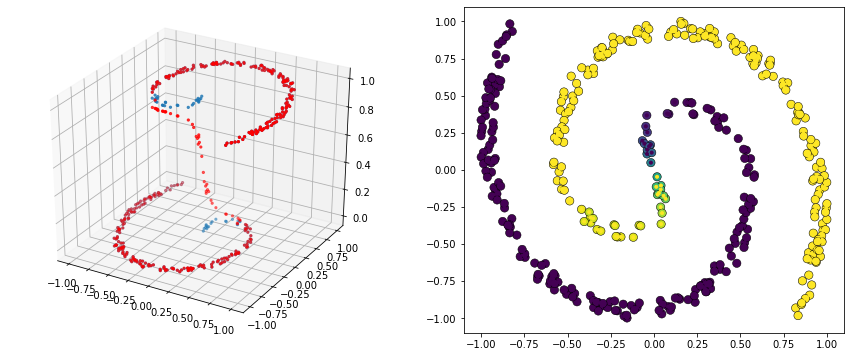

In [18]:
%matplotlib tk

per_step_time = []
info_per_seed = []

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
# ax.view_init(28,20)

for ns in network_seeds:
    torch.manual_seed(ns)
    
    net_lips = nn.Sequential(nn.Linear(2,10),
                             actf(),
                             nn.Linear(10,10),
                             actf(),
                             nn.Linear(10,1),
                             nn.Sigmoid() if use_sigmoid else nn.Identity())

    lpNet = LipschitzPenaltyNet(net_lips, K=1, lamda=lambda_)

    optimizer = torch.optim.Adam(lpNet.parameters(), lr=learning_rate)
    
    for epoch in range(EPOCHS):
        start = time.time()

        yout = lpNet(xx)    
        lpNet.compute_penalty()
        loss = criterion(yout, yy) + lpNet.gp


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        per_step_time.append(time.time()-start)

        if epoch%100 == 0:
            allk = torch.norm(lpNet.dydx, p=2, dim=1, keepdim=True)
            max_k = float(allk.max())
            min_k = float(allk.min())

            print(f'Epoch: {epoch}, Loss:{float(loss-lpNet.gp)}, MaxK: {max_k} MinK: {min_k}')

            ax.clear()
            ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
            ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')

            ax2.clear()
            if use_sigmoid:
                ax2.scatter(X1, X2, c=yout.data.numpy().reshape(Y.shape), s=70, edgecolors='k', lw=0.5)
                ax2.scatter(X1, X2, c=Y, marker='.')
            else:
                ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

            fig.canvas.draw()
            plt.pause(0.01)
            print("\n")
    if use_sigmoid:
        acc = float(((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100)
        info_per_seed.append(
            f'Epoch: {epoch}, Loss:{float(loss-lpNet.gp)}, MaxK: {max_k}, MinK: {min_k}, Acc: {acc}'
        )
    else:
        info_per_seed.append(f'Epoch: {epoch}, Loss:{float(loss-lipsNet.gp)}, MaxK: {max_k}, MinK: {min_k}')

In [19]:
for i in range(len(info_per_seed)):
    print(i, network_seeds[i], info_per_seed[i])
print(np.mean(per_step_time), np.std(per_step_time))

0 147 Epoch: 7499, Loss:0.018283408135175705, MaxK: 1.375279188156128, MinK: 0.0, Acc: 100.0
1 258 Epoch: 7499, Loss:0.06048192083835602, MaxK: 2.255599021911621, MinK: 0.0, Acc: 97.25
2 369 Epoch: 7499, Loss:0.019338227808475494, MaxK: 1.6074994802474976, MinK: 0.0, Acc: 100.0
0.0027519808663262263 0.002713959362209849


In [22]:
# lambda_ = 1